In [34]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
import glob
import cv2
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras.optimizers import SGD
tf.keras.utils.set_random_seed(111)

# To supress any warnings during the flow
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'font.size': 14})

In [2]:
train_datapath = './data/train/'
test_datapath = './data/test/'

In [3]:
class_dirs = os.listdir(train_datapath) 
image_dict = {} 
count_dict = {} 

for cls in class_dirs:
    file_paths = glob.glob(f'{train_datapath}{cls}/*')
    count_dict[cls] = len(file_paths)
    image_path = random.choice(file_paths)
    image_dict[cls] = tf.keras.utils.load_img(image_path)

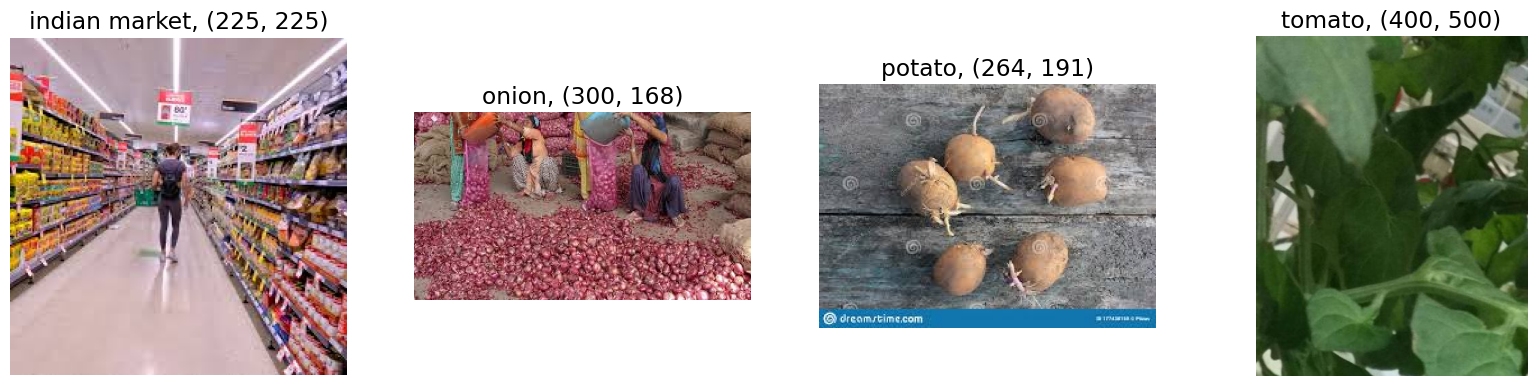

In [4]:
plt.figure(figsize=(20, 15))
for i, (cls,img) in enumerate(image_dict.items()):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f'{cls}, {img.size}')
    plt.axis("off")

Count of training samples per class:
            class  count
0  indian market    599
1          onion    849
2         potato    898
3         tomato    789


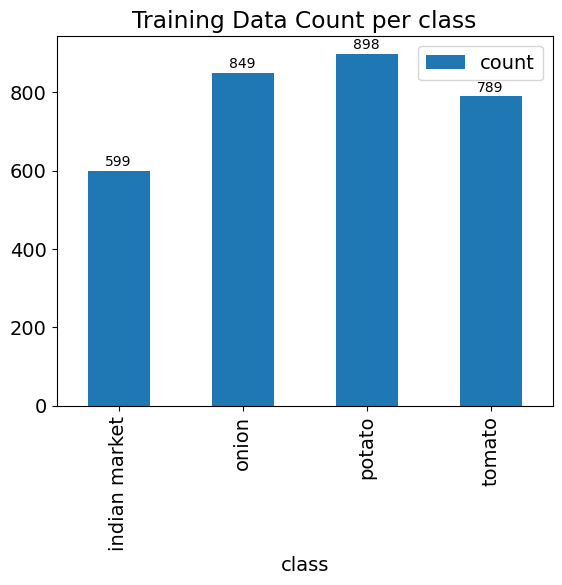

In [5]:
## Let's now Plot the Data Distribution of Training Data across Classes
df_count_train = pd.DataFrame({
    "class": count_dict.keys(),     # keys of count_dict are class labels
    "count": count_dict.values(),   # value of count_dict contain counts of each class
})
print("Count of training samples per class:\n", df_count_train)

# draw a bar plot using pandas in-built plotting function
df_count_train.plot.bar(x='class', y='count', title="Training Data Count per class")
for i, v in enumerate(df_count_train['count']):
    # add value labels on top of each bar
    plt.text(i, v + 5, str(v), ha='center', va='bottom', fontsize=10)

Count of training samples per class:
            class  count
0  indian market     81
1          onion     83
2         potato     81
3         tomato    106


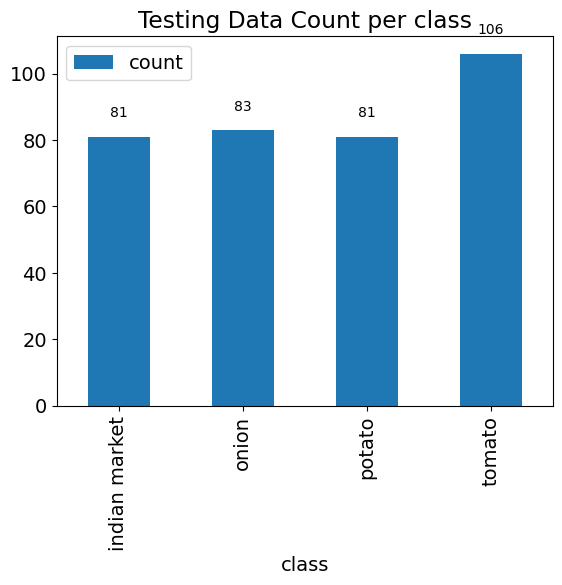

In [6]:
class_dirs = os.listdir(test_datapath) 
image_dict = {} 
count_dict = {} 

for cls in class_dirs:
    file_paths = glob.glob(f'{test_datapath}{cls}/*')
    count_dict[cls] = len(file_paths)
    image_path = random.choice(file_paths)
    image_dict[cls] = tf.keras.utils.load_img(image_path)

## Let's now Plot the Data Distribution of Testing Data across Classes
df_count_train = pd.DataFrame({
    "class": count_dict.keys(),     # keys of count_dict are class labels
    "count": count_dict.values(),   # value of count_dict contain counts of each class
})
print("Count of training samples per class:\n", df_count_train)

# draw a bar plot using pandas in-built plotting function
df_count_train.plot.bar(x='class', y='count', title="Testing Data Count per class")
for i, v in enumerate(df_count_train['count']):
    # add value labels on top of each bar
    plt.text(i, v + 5, str(v), ha='center', va='bottom', fontsize=10)

In [7]:
def split_dataset(dataset_path, train_ratio=0.8, output_path='./data/split/'):
    class_names = os.listdir(dataset_path)

    if not os.path.exists(output_path):
        os.makedirs(output_path)

    for class_dir in class_names:
        class_dir_path = os.path.join(dataset_path, class_dir)
        images = glob.glob(os.path.join(class_dir_path, '*.*'))

        random.shuffle(images)  # Shuffle the images

        split_index = int(len(images) * train_ratio)
        train_images = images[:split_index]
        val_images = images[split_index:]

        # Create directories for training and validation sets
        train_class_dir = os.path.join(output_path, 'train', class_dir)
        val_class_dir = os.path.join(output_path, 'val', class_dir)

        if not os.path.exists(train_class_dir):
            os.makedirs(train_class_dir)
        if not os.path.exists(val_class_dir):
            os.makedirs(val_class_dir)

        # Move images to respective directories
        for img_path in train_images:
            img_name = os.path.basename(img_path)
            new_img_path = os.path.join(train_class_dir, img_name)
            cv2.imwrite(new_img_path, cv2.imread(img_path))

        for img_path in val_images:
            img_name = os.path.basename(img_path)
            new_img_path = os.path.join(val_class_dir, img_name)
            cv2.imwrite(new_img_path, cv2.imread(img_path))

# Split the resized dataset into training and validation sets
split_dataset('./data/train/', train_ratio=0.8, output_path='./data/split/')

In [8]:
BATCH_SIZE = 128
tf.random.set_seed(10)
np.random.seed(10)
train_ds = tf.keras.utils.image_dataset_from_directory("./data/split/train/",shuffle =True, seed=123,image_size=(224, 224),batch_size=BATCH_SIZE)
val_ds   = tf.keras.utils.image_dataset_from_directory("./data/split/val/",shuffle =False, seed=123,image_size=(224, 224),batch_size=BATCH_SIZE)
test_ds = tf.keras.utils.image_dataset_from_directory("./data/test/",shuffle =False, seed=123,image_size=(224, 224),batch_size=BATCH_SIZE)

data_preprocess = tf.keras.Sequential(
    name="data_preprocess",
    layers=[ layers.Rescaling(1.0/255),]
)

# Perform Data Processing on the train, val, test dataset
train_ds = train_ds.map(lambda x, y: (data_preprocess(x), y))
val_ds = val_ds.map(lambda x, y: (data_preprocess(x), y))
test_ds = test_ds.map(lambda x, y: (data_preprocess(x), y))

Found 2507 files belonging to 4 classes.
Found 628 files belonging to 4 classes.
Found 351 files belonging to 4 classes.


In [31]:
noise_path = './data/test/indian market'
onion_path = './data/test/onion'
potato_path = './data/test/potato'
tomato_path = './data/test/tomato'

def classwise_accuracy(class_path, class_name, model_name) :
    paths = []
    for i in os.listdir(class_path):
        paths.append(class_path + "/" + str(i))

    correct = 0
    total = 0

    for i in range(len(paths)):
        total+= 1

        img = tf.keras.utils.load_img(paths[i])
        img = tf.keras.utils.img_to_array(img)
        img = tf.image.resize(img, (224, 224))
        img = tf.expand_dims(img, axis = 0)

        pred = model_name.predict(img, verbose=0)
        if tf.argmax(pred[0]) == class_names.index(f"{class_name}"):
            correct+= 1

    print(f"Accuracy for class {class_name} is {round((correct/total)*100, 2)}% consisting of {len(paths)} images")


In [9]:
def create_cnn_classifier(input_shape=(224, 224, 3), num_classes=10):
    model = tf.keras.models.Sequential()

    # First Convolutional Layer
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Second Convolutional Layer
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Third Convolutional Layer
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output and add Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout for regularization
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

input_shape = (224, 224, 3)  # Image dimensions
num_classes = 4  # Number of classes in your dataset
cnn_model = create_cnn_classifier(input_shape, num_classes)

# Summary of the model
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
log_dir = "logs/Custom_CNN"
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [11]:
opt = SGD(learning_rate=0.005, momentum=0.99)
cnn_model.compile(
    optimizer=opt,
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)
print(cnn_model.optimizer.get_config())
history = cnn_model.fit(train_ds,  epochs=10,
                    validation_data=val_ds,
                    callbacks=[tensorboard_cb]
                   )

{'name': 'SGD', 'learning_rate': 0.004999999888241291, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'momentum': 0.99, 'nesterov': False}
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.3089 - loss: 1.3539 - val_accuracy: 0.6290 - val_loss: 1.0852
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 74s 4s/step - accuracy: 0.4662 - loss: 1.3901 - val_accuracy: 0.4761 - val_loss: 1.2359
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.4812 - loss: 1.1432 - val_accuracy: 0.6640 - val_loss: 0.8106
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.4830 - loss: 1.1738 - val_accuracy: 0.5111 - val_loss: 0.9708
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.5718 - loss: 0.9759 - val_accuracy: 0.6019 - val_loss: 0.8593
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accur

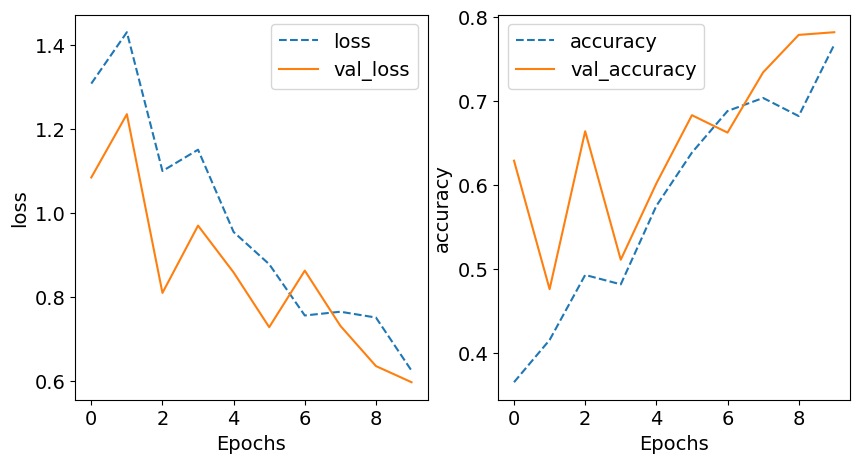

In [13]:
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

training_plot(['loss', 'accuracy'], history)

In [14]:
# Evaluate the model
loss, acc = cnn_model.evaluate(test_ds, verbose=2)
print("Accuracy: {:5.2f}%".format(100 * acc))

3/3 - 2s - 689ms/step - accuracy: 0.7236 - loss: 0.6635
Accuracy: 72.36%


In [19]:
test_images = []

test_dir = './data/test/'
class_names = os.listdir(test_dir)
for folder in os.listdir(test_dir):
  for image in os.listdir(test_dir + '/' + folder):
    test_images.append(os.path.join(test_dir, folder, image))

def grid_test_model(model_name):

  fig = plt.figure(1, figsize=(17, 11))
  plt.axis('off')
  n = 0
  for i in range(8):
    n += 1

    img_0 = tf.keras.utils.load_img(random.choice(test_images))
    img_0 = tf.keras.utils.img_to_array(img_0)
    img_0 = tf.image.resize(img_0, (225, 225))
    img_1 = tf.expand_dims(img_0, axis = 0)

    pred = model_name.predict(img_1)
    predicted_label = tf.argmax(pred, 1).numpy().item()

    for item in pred :
      item = tf.round((item*100))

    plt.subplot(2, 4, n)
    plt.axis('off')
    plt.title(f'prediction : {class_names[predicted_label]}\n\n'
              f'{item[0]} % {class_names[0]}\n'
              f'{item[1]} % {class_names[1]}\n'
              f'{item[2]} % {class_names[2]}\n'
              f'{item[3]} % {class_names[3]}\n')
    plt.imshow(img_0/255)
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


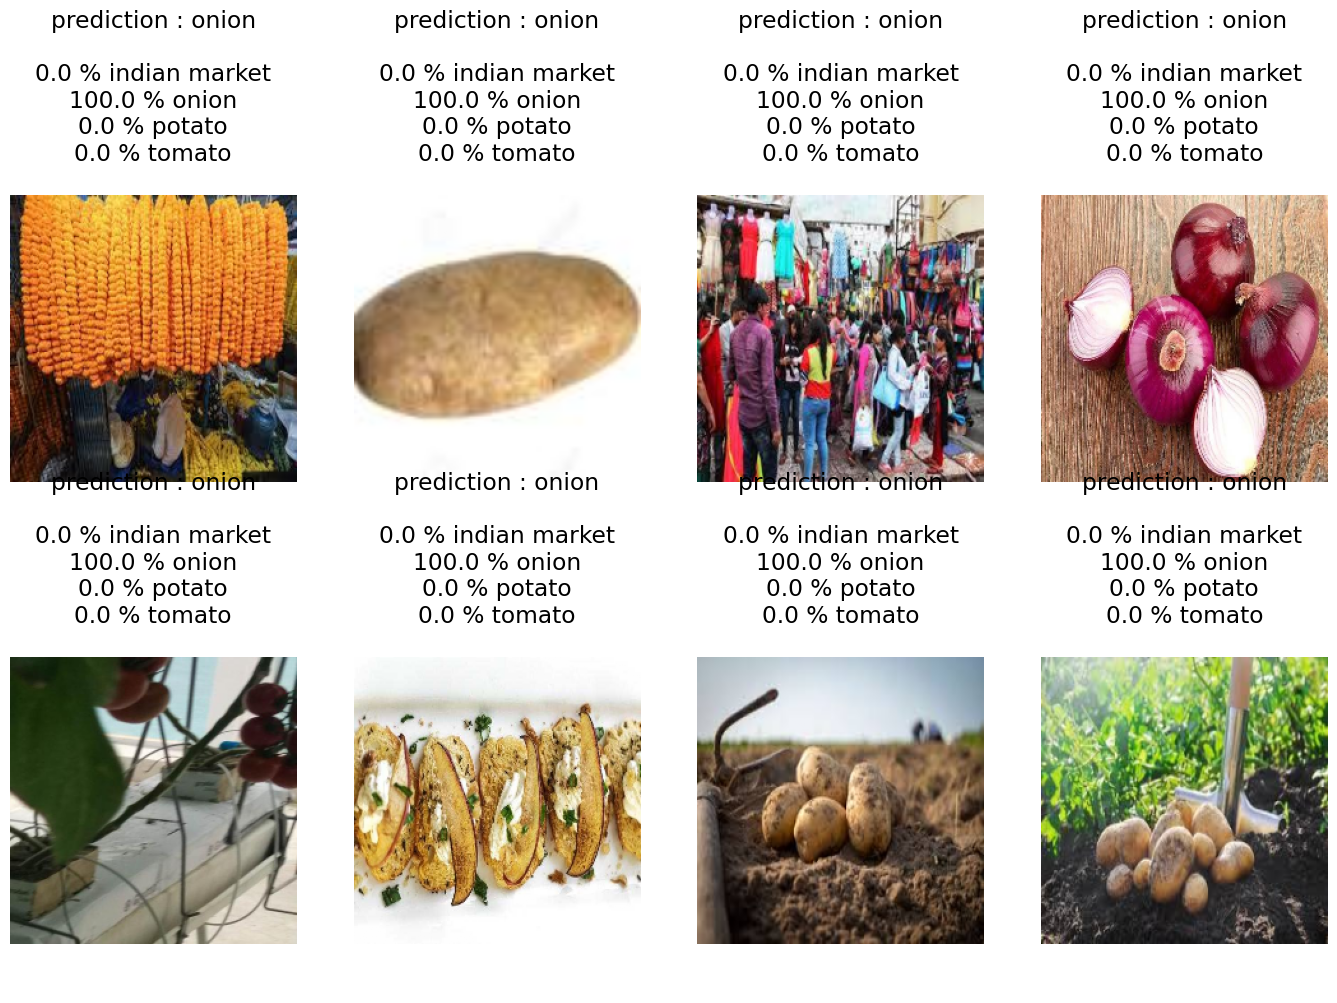

In [21]:
grid_test_model(cnn_model)

In [32]:
classwise_accuracy(noise_path, 'indian market', cnn_model)
classwise_accuracy(onion_path, 'onion', cnn_model)
classwise_accuracy(potato_path, 'potato', cnn_model)
classwise_accuracy(tomato_path, 'tomato', cnn_model)

Accuracy for class indian market is 7.41% consisting of 81 images
Accuracy for class onion is 100.0% consisting of 83 images
Accuracy for class potato is 0.0% consisting of 81 images
Accuracy for class tomato is 0.0% consisting of 106 images


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 460ms/step


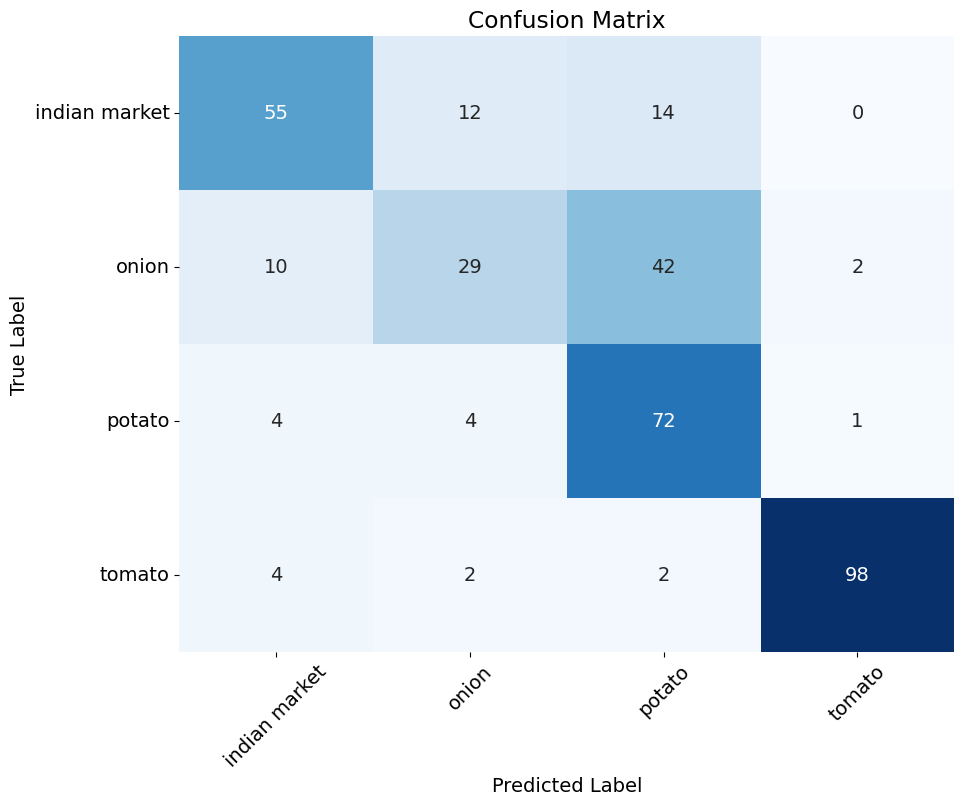

               precision    recall  f1-score   support

indian market       0.75      0.68      0.71        81
        onion       0.62      0.35      0.45        83
       potato       0.55      0.89      0.68        81
       tomato       0.97      0.92      0.95       106

     accuracy                           0.72       351
    macro avg       0.72      0.71      0.70       351
 weighted avg       0.74      0.72      0.71       351



In [36]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

def get_class_names(dataset_path):
    class_names = os.listdir(dataset_path)
    return class_names

def get_test_labels(test_ds):
    y_true = []
    for _, labels in test_ds:
        y_true.extend(labels.numpy())
    return np.array(y_true)

# Get class names from the test dataset
class_names = get_class_names(test_datapath)
# Get true labels from the test dataset
y_true = get_test_labels(test_ds)
# Get predictions from the model (predict on the whole dataset at once)
y_pred_probs = cnn_model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names)
print(classification_report(y_true, y_pred, target_names=class_names))

## Overfitting

In [37]:
augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomTranslation(height_factor = 0.2, width_factor=0.2)
])


AUTOTUNE = tf.data.AUTOTUNE
train_ds = (train_ds
            .map(lambda x, y: (augmentation(x, training=True), y),
                 num_parallel_calls=AUTOTUNE)
            .prefetch(AUTOTUNE))
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

In [39]:
def create_revamp_cnn_classifier(input_shape=(224, 224, 3), num_classes=10):
    model = tf.keras.models.Sequential()

    # First Convolutional Layer
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Second Convolutional Layer
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Third Convolutional Layer
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output and add Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout for regularization
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

input_shape = (224, 224, 3)  # Image dimensions
num_classes = 4  # Number of classes in your dataset
revamp_cnn_model = create_revamp_cnn_classifier(input_shape, num_classes)

# Summary of the model
revamp_cnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

{'name': 'SGD', 'learning_rate': 0.004999999888241291, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'momentum': 0.99, 'nesterov': False}
Epoch 1/30


20/20 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.2877 - loss: 1.3567 - val_accuracy: 0.3822 - val_loss: 1.2572
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.4795 - loss: 1.1972 - val_accuracy: 0.5685 - val_loss: 0.9718
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - accuracy: 0.5036 - loss: 1.0828 - val_accuracy: 0.4809 - val_loss: 1.1148
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.5078 - loss: 1.0550 - val_accuracy: 0.5000 - val_loss: 1.0199
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.5939 - loss: 0.9448 - val_accuracy: 0.7611 - val_loss: 0.6670
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.6783 - loss: 0.7791 - val_accuracy: 0.7580 - val_loss: 0.6369
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.7097 - loss: 0.6800 - val_accuracy: 0.7580 - val_loss: 0.6012
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.7395 - loss: 0.6313 - val_accuracy: 0.7850 - val_loss: 0.5503
Epo

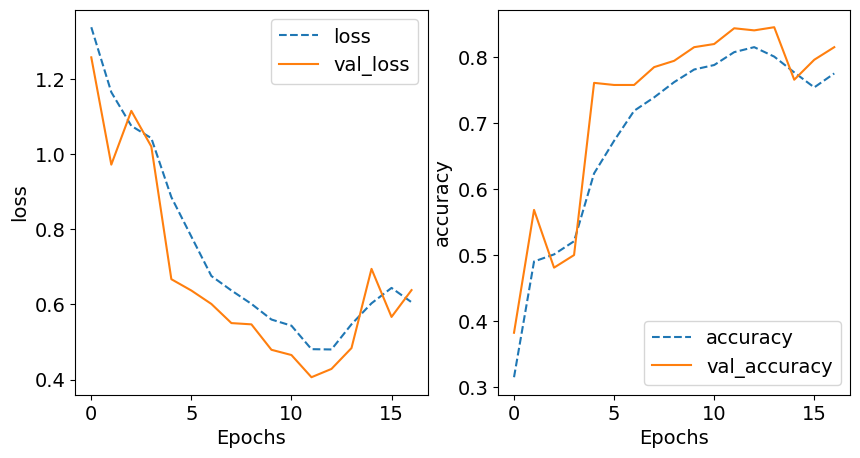

In [41]:
log_dir = "logs/Custom_Revamped_CNN"
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("CNN_best_augmented.keras", save_best_only = True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', patience = 5, restore_best_weights = True
)

opt = SGD(learning_rate=0.005, momentum=0.99)
revamp_cnn_model.compile(
    optimizer=opt,
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)
print(revamp_cnn_model.optimizer.get_config())
revamp = revamp_cnn_model.fit(train_ds,  epochs=30,
                    validation_data=val_ds,
                    callbacks=[tensorboard_cb, checkpoint_cb, early_stopping_cb]
                   )

training_plot(['loss', 'accuracy'], revamp)

# Evaluate the model
loss, acc = revamp_cnn_model.evaluate(test_ds, verbose=2)
print("Accuracy: {:5.2f}%".format(100 * acc))

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/stepWARNING:tensorflow:5 out of the last 454 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002173D0B9B40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 702ms/step


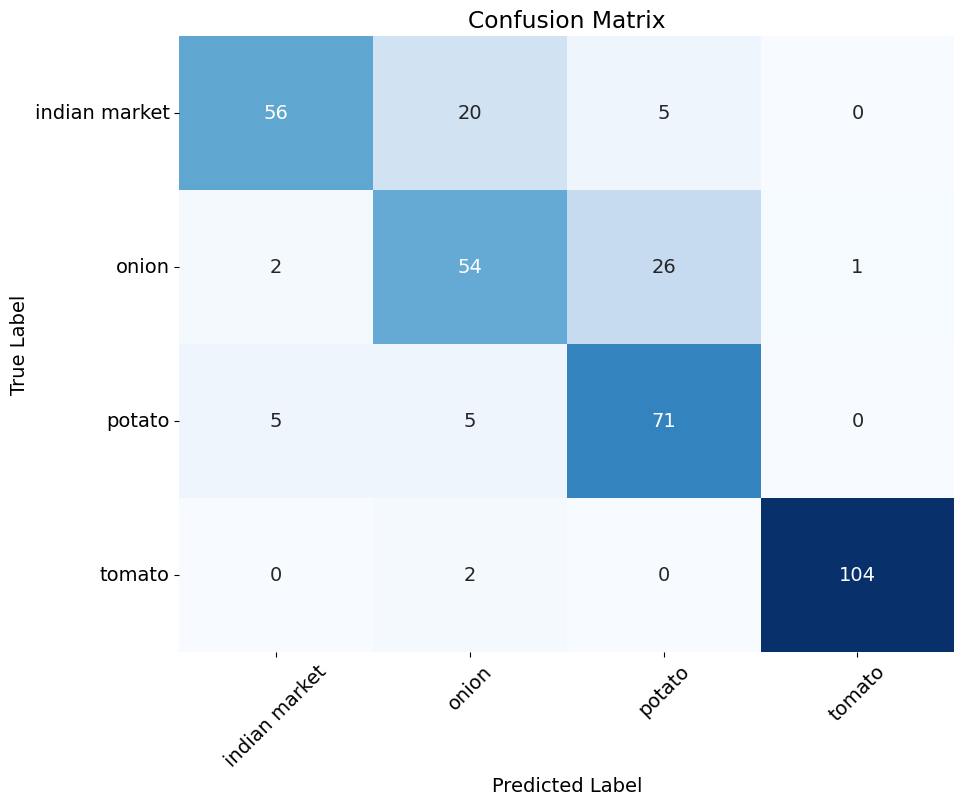

               precision    recall  f1-score   support

indian market       0.89      0.69      0.78        81
        onion       0.67      0.65      0.66        83
       potato       0.70      0.88      0.78        81
       tomato       0.99      0.98      0.99       106

     accuracy                           0.81       351
    macro avg       0.81      0.80      0.80       351
 weighted avg       0.82      0.81      0.81       351



In [42]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

def get_class_names(dataset_path):
    class_names = os.listdir(dataset_path)
    return class_names

def get_test_labels(test_ds):
    y_true = []
    for _, labels in test_ds:
        y_true.extend(labels.numpy())
    return np.array(y_true)

# Get class names from the test dataset
class_names = get_class_names(test_datapath)
# Get true labels from the test dataset
y_true = get_test_labels(test_ds)
# Get predictions from the model (predict on the whole dataset at once)
y_pred_probs = revamp_cnn_model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names)
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


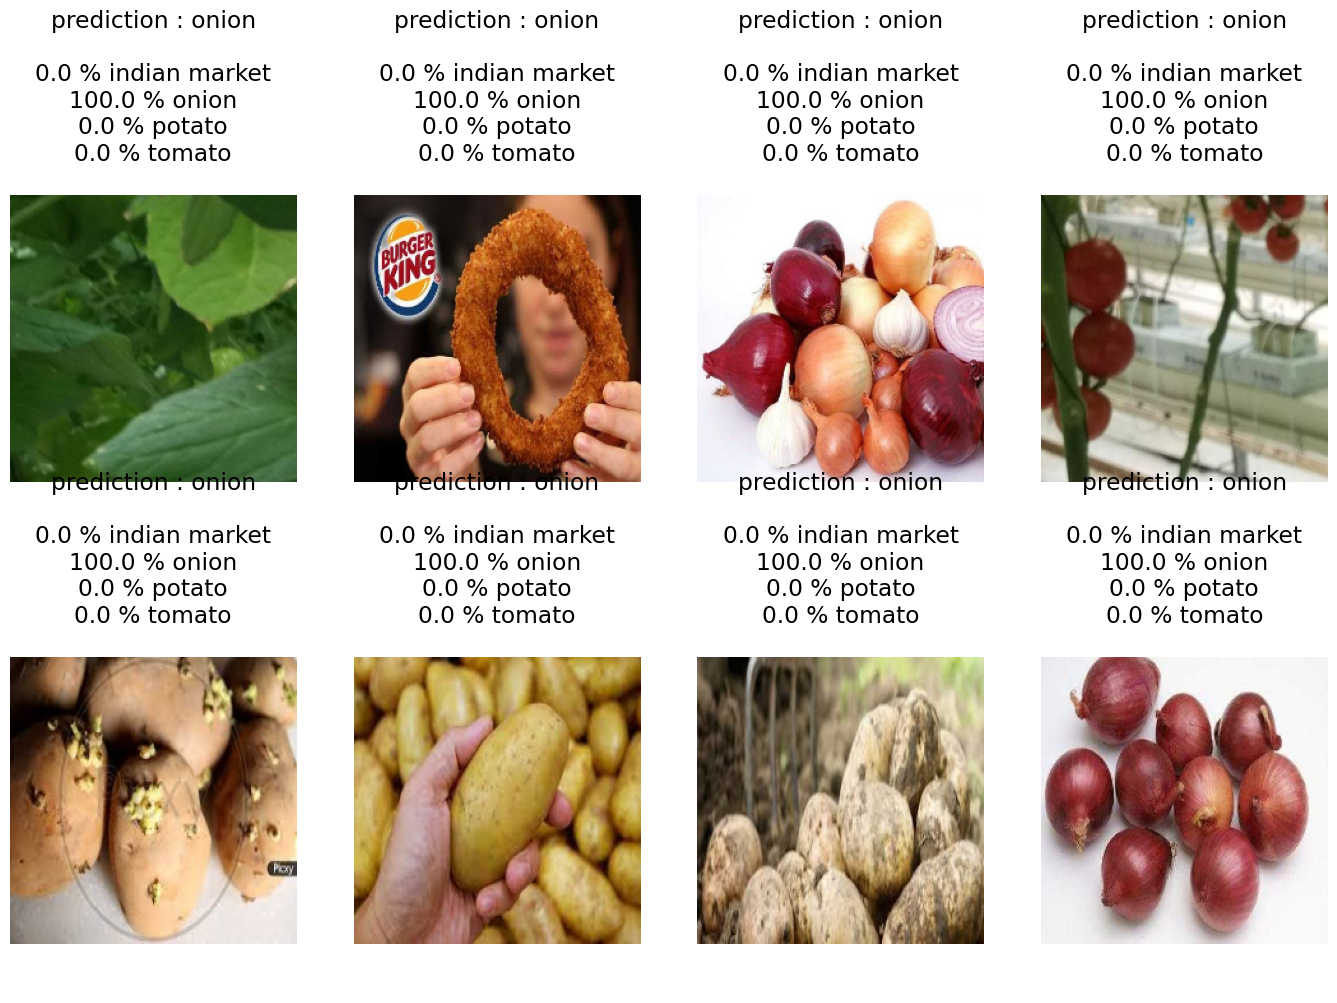

Accuracy for class indian market is 43.21% consisting of 81 images
Accuracy for class onion is 98.8% consisting of 83 images
Accuracy for class potato is 2.47% consisting of 81 images
Accuracy for class tomato is 0.0% consisting of 106 images


In [43]:
grid_test_model(revamp_cnn_model)

classwise_accuracy(noise_path, 'indian market', revamp_cnn_model)
classwise_accuracy(onion_path, 'onion', revamp_cnn_model)
classwise_accuracy(potato_path, 'potato', revamp_cnn_model)
classwise_accuracy(tomato_path, 'tomato', revamp_cnn_model)

## VGG-19

In [44]:
augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomTranslation(height_factor = 0.2, width_factor=0.2)
])


AUTOTUNE = tf.data.AUTOTUNE
train_ds = (train_ds
            .map(lambda x, y: (augmentation(x, training=True), y),
                 num_parallel_calls=AUTOTUNE)
            .prefetch(AUTOTUNE))
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

# load base model
base_model_3 = tf.keras.applications.vgg19.VGG19(input_shape=(224, 224, 3), include_top = False)


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [51]:
# append classification layer
model_3 = base_model_3.output
IMAGE_SIZE = (224, 224)

model_3 = tf.keras.Sequential([
            #Normalizing 0-255 into 0 to 1
            tf.keras.layers.Rescaling(1./255,  input_shape=(*IMAGE_SIZE, 3)),
            base_model_3,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(rate = 0.1),
            tf.keras.layers.Dense(4, activation = 'softmax')
        ])

model_3.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,026,436 (76.39 MB)

 Trainable params: 20,026,436 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
log_dir_vgg = "logs/VGG19"

tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir_vgg, histogram_freq=1)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("VGG19.keras", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', patience = 5, restore_best_weights=True
)
opt = SGD(learning_rate=0.005, momentum=0.99)
model_3.compile(
    optimizer=opt,
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)
print(model_3.optimizer.get_config())
history_vgg = model_3.fit(train_ds,  epochs=10,
                    validation_data=val_ds,
                    callbacks=[tensorboard_cb, checkpoint_cb, early_stopping_cb]
                   )

{'name': 'SGD', 'learning_rate': 0.004999999888241291, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'momentum': 0.99, 'nesterov': False}
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1998s 97s/step - accuracy: 0.2582 - loss: 1.4748 - val_accuracy: 0.1911 - val_loss: 1.3880
Epoch 2/10
15/20 ━━━━━━━━━━━━━━━━━━━━ 9:41 116s/step - accuracy: 0.2671 - loss: 2.1186

KeyboardInterrupt: 